# Figure 4

## a

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np

from flyvision import EnsembleView
from flyvision.analysis.clustering import check_markers
from flyvision.analysis.moving_bar_responses import MovingEdgeResponseView
from flyvision.datasets import MovingEdge
from flyvision.plots import plots, plt_utils
from flyvision.utils.activity_utils import CellTypeArray
from flyvision.utils.groundtruth_utils import tuning_curves

In [5]:
ensemble = EnsembleView("flow/0000")

Loading ensemble:   0%|          | 0/50 [00:00<?, ?it/s]

[2024-09-28 05:21:16] ensemble:138 Loaded 50 networks.


In [16]:
stims_and_resps = ensemble.movingedge_responses()

In [17]:
stims_and_resps['responses'] /= (norm := ensemble.responses_norm(rectified=True))

In [8]:
# retrieve cluster indices for averaging across best clusters
cell_types = [
    "L1",
    "L2",
    "L3",
    "L4",
    "L5",
    "Mi1",
    "Tm3",
    "Mi4",
    "Mi9",
    "CT1(M10)",
    "T4a",
    "T4b",
    "T4c",
    "T4d",
    "T5a",
    "T5b",
    "T5c",
    "T5d",
    "Tm1",
    "Tm2",
    "Tm4",
    "Tm9",
    "CT1(Lo1)",
    "TmY3",
]
cluster_indices = {}
for cell_type in cell_types:
    if cell_type not in cluster_indices:
        cluster_indices[cell_type] = ensemble.cluster_indices(cell_type)

[2024-09-28 05:21:39] clustering:640 Loaded L1 embedding and clustering from /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/umap_and_clustering.


[2024-09-28 05:21:40] clustering:640 Loaded L2 embedding and clustering from /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/umap_and_clustering.
[2024-09-28 05:21:40] clustering:640 Loaded L3 embedding and clustering from /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/umap_and_clustering.
[2024-09-28 05:21:40] clustering:640 Loaded L4 embedding and clustering from /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/umap_and_clustering.
[2024-09-28 05:21:42] clustering:640 Loaded L5 embedding and clustering from /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/umap_and_clustering.
[2024-09-28 05:21:42] clustering:640 Loaded Mi1 embedding and clustering from /groups/turaga/home/lappalainenj/FlyVis/private/flyvision/data/results/flow/0000/umap_and_clustering.
[2024-09-28 05:21:42] clustering:640 Loaded Tm3 embedding and clustering from /groups/turaga/home/lappal

In [10]:
from flyvision.analysis.moving_bar_responses import plot_angular_tuning

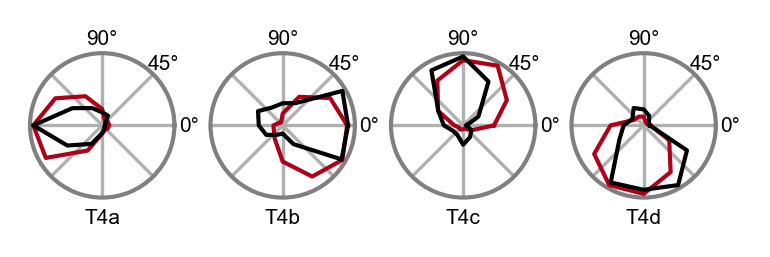

In [20]:
# plot the tuning across the best clusters
fig, axes, _ = plots.plt_utils.get_axis_grid(
    range(4),
    projection="polar",
    aspect_ratio=4,
    figsize=[2.95, 0.83],
    wspace=0.25,
)
for i, cell_type in enumerate(["T4a", "T4b", "T4c", "T4d"]):
    plot_angular_tuning(
        stims_and_resps.sel(network_id=cluster_indices[cell_type][0]),
        cell_type=cell_type,
        intensity=1,
        fig=fig,
        ax=axes[i],
        groundtruth=True,
        groundtruth_linewidth=1.0,
        average_models=True,
        model_dim=2,
        zorder=100
    )
    axes[i].set_xlabel(cell_type)

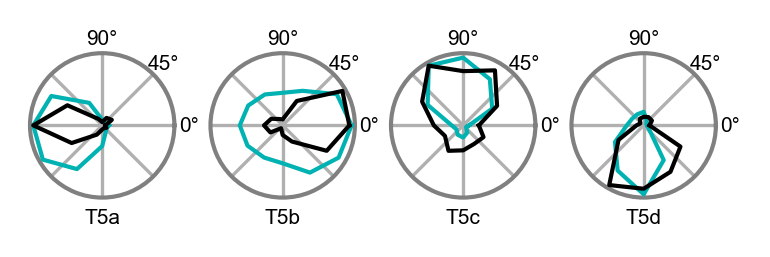

In [21]:
fig, axes, _ = plots.plt_utils.get_axis_grid(
    range(4),
    projection="polar",
    aspect_ratio=4,
    figsize=[2.95, 0.83],
    wspace=0.25,
)
for i, cell_type in enumerate(["T5a", "T5b", "T5c", "T5d"]):
    plot_angular_tuning(
        stims_and_resps.sel(network_id=cluster_indices[cell_type][0]),
        cell_type=cell_type,
        intensity=0,
        fig=fig,
        ax=axes[i],
        groundtruth=True,
        groundtruth_linewidth=1.0,
        average_models=True,
        model_dim=2,
        zorder=100
    )
    axes[i].set_xlabel(cell_type)

## b

In [22]:
from datamate import namespacify

from flyvision.analysis.moving_edge_currents import CellTypeArray, MovingEdgeCurrentView
from flyvision.datasets import MovingEdge

In [23]:
target_types = ["T4c"]

In [24]:
dataset = MovingEdge(
        widths=[80],
        offsets=[-10, 11],
        intensities=[0, 1],
        speeds=[19],
        height=80,
        bar_loc_horizontal=0.0,
        shuffle_offsets=False,
        post_pad_mode="continue",
        t_pre=1.0,
        t_post=1.0,
        dt=1 / 200,
        angles=[0, 45, 90, 180, 225, 270],
)

In [25]:
cell_type = "T4c"
subdir = f"movingedge_responses/{ensemble[0].checkpoints.current_chkpt_key}/currents"

AttributeError: 'Checkpoints' object has no attribute 'current_chkpt_key'

In [12]:
current_views = {}

In [13]:
norm = CellTypeArray(ensemble.responses_norm(rectified=False), 
                     ensemble[0].connectome)

In [14]:
for target_type in target_types:
    if target_type not in current_views:
        current_views[target_type] = MovingEdgeCurrentView(
            ensemble, target_type, subdir, dataset.arg_df
        )
    view = current_views[target_type]


In [15]:
view.shape

(49, 12, 485, 2)

In [16]:
current_views[target_type] = view.divide_by_given_norm(norm)

In [17]:
current_views[target_type].shape

(49, 12, 485, 2)

In [18]:
hide_source_types="auto"
hide_source_types_bins=7
hide_source_types_cut_off_edge=1
hide_source_types_mode="below_cut_off"

In [19]:
view.shape

(49, 12, 485, 2)

In [20]:
inputs = namespacify(
    {
        cell_type: dict(majors={}, minors={})
        for cell_type in target_types
    }
)

for cell_type in target_types:
    if cell_type not in current_views:
        current_views[cell_type] = MovingEdgeCurrentView(
            ensemble, cell_type, subdir, dataset.arg_df
        )
    view = current_views[cell_type]

    inputs[cell_type].majors = view.model_selection(
        cluster_indices[cell_type][0]
    ).filter_source_types(
        hide_source_types,
        hide_source_types_bins,
        hide_source_types_cut_off_edge,
        "below_cut_off",
    )
    inputs[cell_type].minors = view.model_selection(
        cluster_indices[cell_type][0]
    ).filter_source_types(
        hide_source_types,
        hide_source_types_bins,
        hide_source_types_cut_off_edge,
        "above_cut_off",
    )

In [21]:
current_view = current_views["T4c"]

Text(0.5, 0, 'time (s)')

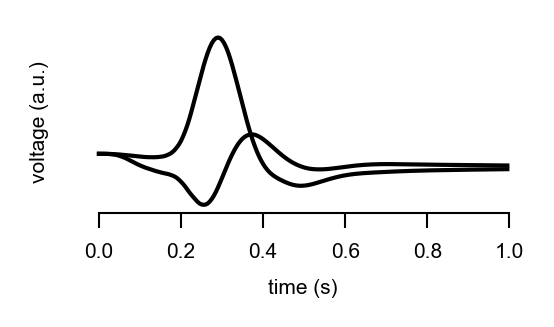

In [22]:
fig, ax = current_view.model_selection(cluster_indices[cell_type][0]).plot_response(
    1, 90, t_end=1.0
)
xlim_responses = ax.get_xlim()
ax.set_ylabel("voltage (a.u.)", fontsize=5)
ax.set_xlabel("time (s)", fontsize=5)

Text(0, 0.5, 'current (a.u.)')

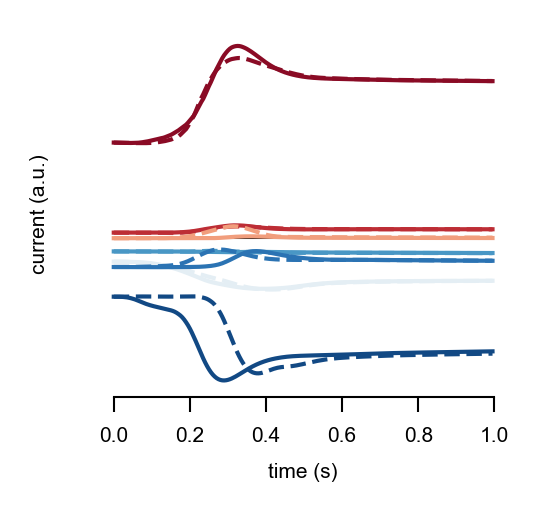

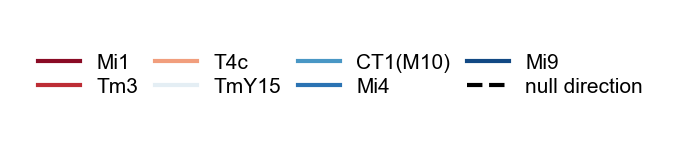

In [23]:
fig, ax, legend_fig, legend_ax = current_view.model_selection(
    cluster_indices[cell_type][0]
).plot_temporal_contributions(
    1,
    90,
    t_start=0,
    t_end=1,
    model_average=True,
    legend=False,
    sum_exc_inh=False,
    only_sum=False,
    max_figure_height_cm=3.3941,
    panel_height_cm=3.3941,
    max_figure_width_cm=4.0513,
    panel_width_cm=4.0513,
    hide_source_types=["T4a", "T4b", "T5c", "Mi10", "C3"]
)
ylim = ax.get_ylim()
ax.set_ylabel("current (a.u.)", fontsize=5)

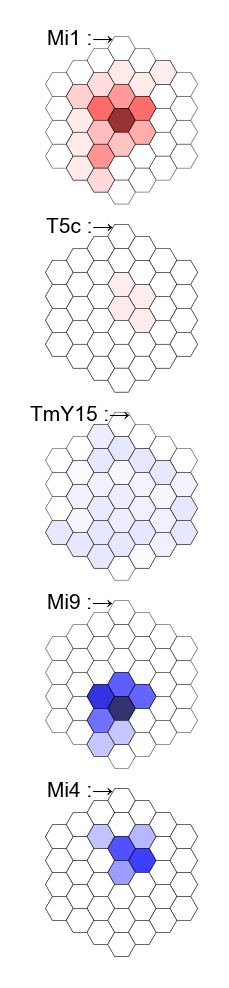

In [24]:
fig, ax, _ = current_view.model_selection(
    cluster_indices[cell_type][0]
).plot_spatial_contribution_grid(
    t_start=0,
    t_end=1,
)

## d

In [25]:
from datamate import Namespace

from flyvision import utils
from flyvision.utils import hex_utils
from flyvision.datasets.dots import SpatialImpulses
from flyvision.plots import plt_utils
from flyvision.utils.activity_utils import StimulusResponseIndexer

from flyvision.analysis.views import plot_strf

In [38]:
ensemble = EnsembleView("flow/0000", "best", "validation", "epe")

Loading ensemble:   0%|          | 0/50 [00:00<?, ?it/s]

[2024-09-12 15:01:16] Loaded 50 networks.


In [41]:
dt = 1/200
subdir = f"spatial_impulses_responses/{ensemble[0].checkpoints.current_chkpt_key}"

In [42]:
config = Namespace(
    impulse_durations=[0.005, 0.02],
    max_extent=4,
    dot_column_radius=0,
    bg_intensity=0.5,
    t_stim=2,
    dt=dt,
    n_ommatidia=721,
    t_pre=1.0,
    t_post=0,
    intensity=1.0,
    mode="impulse",
    device="cuda",
)
dataset = SpatialImpulses(**config)

In [43]:
arg_df = dataset.arg_df
arg_df["uv"] = list([list(v) for v in zip(arg_df.u, arg_df.v)])
cell_types = ensemble[0].connectome.unique_cell_types[:].astype(str)

In [44]:
strf_view = StimulusResponseIndexer(arg_df, 
                                    CellTypeArray(None, cell_types=cell_types), 
                                    dataset.dt, 
                                    0,
                                    stim_sample_dim=1,
                                    temporal_dim=2)

In [45]:
# relevant stimuli arguments
intensity = 1
stim_arg_index = StimulusResponseIndexer.where_stim_args_index_static(dataset.arg_df, intensity=intensity).to_numpy()

In [46]:
# relevant time window
t_start = 0
t_end = 0.250
time = (
    np.arange(
        0,
        ensemble[0]
        .dir[subdir]
        .network_states.nodes.activity_central.shape[1],
        1,
    )
    * dataset.dt
    - dataset.t_pre
)
temporal_index = np.arange(len(time))[(time >= t_start) & (time <= t_end)]
start_index = temporal_index.min()
stop_index = temporal_index.max()

In [47]:
strf_responses  = ensemble.stored_responses("spatial_impulses_responses", 
                                            central=True, 
                                            slice=(stim_arg_index, 
                                                   slice(start_index, 
                                                         stop_index)))

In [48]:
arg_df = dataset.arg_df.iloc[stim_arg_index]
arg_df.reset_index(drop=True, inplace=True)

In [354]:
norm = ensemble.responses_norm()

In [356]:
# update ir view
strf_view = StimulusResponseIndexer(arg_df, 
                                    CellTypeArray(strf_responses, cell_types=cell_types), 
                                    dataset.dt, 
                                    0,
                                    stim_sample_dim=1,
                                    temporal_dim=2,
                                    time=time[start_index:stop_index])
strf_view = strf_view.divide_by_given_array(norm[:], dims=(0, -1))

In [380]:
from flyvision.utils.color_utils import flash_response_color_labels, adapt_color_alpha
from flyvision.plots.figsize_utils import fit_panel_size
from scipy.signal import find_peaks

In [389]:
srf_cell_types = [
    "Mi1", "Tm3", "Mi4", "Mi9", "CT1(M10)",
    "Tm1", "Tm2", "Tm4", "Tm9", "CT1(Lo1)"
             ]

In [390]:
def strf_to_srf(x):
    extr_index = find_peaks(np.abs(x[:, x.shape[1]//2]))[0]
    if extr_index.any():
        extr_index = extr_index[0]
    else:
        extr_index = 0
    return x[extr_index].squeeze()

In [392]:
mean_srfs = {}
for cell_type in srf_cell_types:
    strfs = strf_view.where_stim_args(t_impulse=0.02)[cell_type][cluster_indices[cell_type][0]]
    x = strfs[:].mean(axis=0).squeeze().T

    # subtracting the spatial average at timepoint 0 after averaging to center
    x -= x[0].mean(axis=0)
    mean_srfs[cell_type] = strf_to_srf(x)

In [400]:
cell_type = "Mi9"
strfs = strf_view.where_stim_args(t_impulse=0.02)[cell_type][cluster_indices[cell_type][0]]
x = strfs[:].mean(axis=0).squeeze().T

# subtracting the spatial average at timepoint 0 after averaging to center
x -= x[0].mean(axis=0)

In [401]:
nodes = ensemble[0].connectome.nodes.to_df()

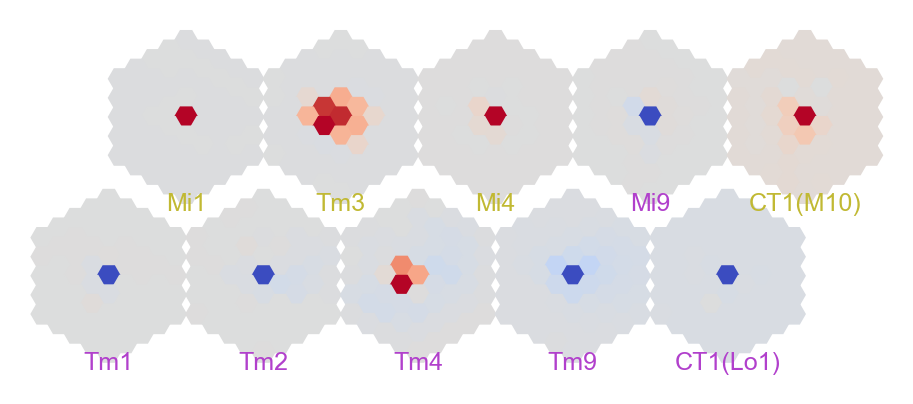

In [415]:
from flyvision.utils.hex_utils import hex_rows
from flyvision.plots.plt_utils import ax_scatter
from flyvision.plots.plots import hex_scatter

x, y = hex_rows(2, 5)
fig, axes, pos = ax_scatter(
    x, y, figsize=[3.5, 2], hpad=0, wpad=0.1, wspace=-0.5, hspace=-0.4
)

axes = np.array(axes).reshape(2, 5)

for i, row in enumerate(np.array(srf_cell_types).reshape(2, 5)):
    for j, cell_type in enumerate(row):
        crange = np.max(np.abs(mean_srfs[cell_type]))
        u, v = nodes[nodes.type==cell_type][["u", "v"]].values.T
        fig, ax, _ = hex_scatter(
            dataset.dots.u,
            dataset.dots.v,
            mean_srfs[cell_type],
            cmap=plt.cm.coolwarm,
            vmin=-crange,
            vmax=crange,
            figsize=[3, 3],
            cbar=False,
            fig=fig,
            ax=axes[1 - i, j],
        )
        ax.set_xlabel(cell_type, fontsize=6, labelpad=-10)

for ax in axes.flatten():
    flash_response_color_labels(ax)

## e

In [418]:
from flyvision.datasets.dots import CentralImpulses

In [479]:
config = Namespace(intensity=1, 
                   impulse_durations=[5e-3, 20e-3, 50e-3, 100e-3, 200e-3, 300e-3], 
                   dt=1 / 200, 
                   dot_column_radius=0,
                   t_stim=2,
                   n_ommatidia=721,
                     t_pre=1.0,
                        t_post=0,
                        mode="impulse",
                        device="cuda",
)
dataset = CentralImpulses(**config)
dt = config.dt

In [480]:
central_impulse_responses = ensemble.stored_responses("central_impulses_responses", central=True)

In [481]:
cir_view = StimulusResponseIndexer(
    dataset.arg_df,
    CellTypeArray(central_impulse_responses, connectome=ensemble.connectome),
    dataset.dt,
    dataset.t_pre,
    stim_sample_dim=1,
    temporal_dim=2,
)

In [482]:
norm = ensemble.responses_norm(rectified=False)

In [493]:
trf_cell_types = np.array(
    [
        "Mi1",
        "Tm3",
        "Mi4",
        "Mi9",
        "CT1(M10)",
        "Tm1",
        "Tm2",
        "Tm4",
        "Tm9",
        "CT1(Lo1)",
        "L1",
        "L2",
        "L3",
        "L4",
        "L5",
    ]
).reshape(5, 3, order="F")

In [484]:
cir_view = (cir_view
                .divide_by_given_array(norm[:], dims=(0, -1))
                .between_seconds(-cir_view.dt, 1.0)
           )

In [485]:
from flyvision.plots.plt_utils import truncate_colormap

In [486]:
durations = [0.02, 0.05, 0.1, 0.2, 0.3]
on_cmap = truncate_colormap(plt.cm.Blues_r, minval=0., maxval=0.4).resampled(len(durations))
off_cmap = truncate_colormap(plt.cm.Blues_r, minval=0.5, maxval=0.9).resampled(len(durations))
cmaps = {
    1.: [on_cmap(i) for i in range(on_cmap.N)][::-1],
    0: [off_cmap(i) for i in range(off_cmap.N)][::-1]
}

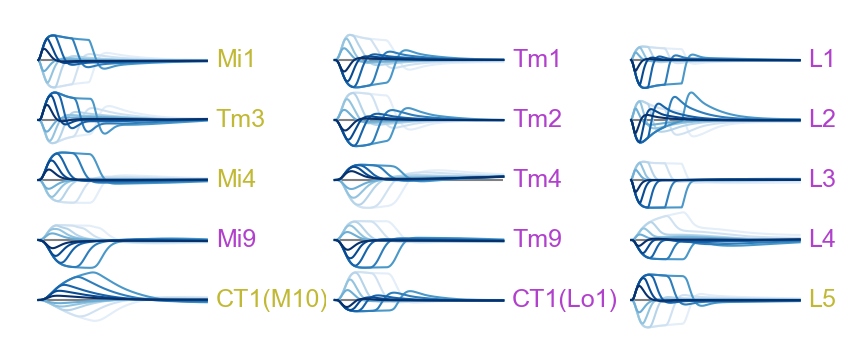

In [494]:
fig, axes = fit_panel_size(
    5,
    3,
    max_figure_height_cm=5.35,
    max_figure_width_cm=8,
    panel_width_cm=8 / 3,
    panel_height_cm=5.35 / 10,
).axis_grid(wspace=0.6, hspace=0.0, as_matrix=True)
for i, row in enumerate(trf_cell_types):
    for j, cell_type in enumerate(row):
        ax = axes[i, j]
        for q, duration in enumerate(durations[::-1]):
            for intensity in [0, 1]:
                color = cmaps[intensity][q] #plt.cm.Blues(256) if intensity == 1 else plt.cm.Blues(128)
#                 linestyle = "solid" if intensity == 1 else "dashed"
                zorder = 1 if intensity == 1 else 0
                r = (
                    cir_view.where_stim_args(t_impulse=duration, intensity=intensity)
                    .cell_type(cell_type)[cluster_indices[cell_type][0]]
                )
                trf = r[:].squeeze().T
                mean = trf.mean(axis=1)
                # subtract baseline after model averaging to plot it centered
                mean = mean - mean[[0]]
                #         ci = np.quantile(trf, [0.25, 0.75], axis=1)
                ax.plot(r.time, mean, linewidth=0.5, color=color, zorder=zorder)
        ax.hlines(
            mean[0],
            r.time.min(),
            r.time.max(),
            linewidth=0.5,
            color="0.5",
            zorder=-1,
        )

        plt_utils.rm_spines(ax)
        ax.yaxis.set_label_position("right")
        ax.set_ylabel(
            cell_type,
            fontsize=6,
            rotation=0,
            ha="left",
            va="center",
            labelpad=0.1,
        )
        #         ylim = np.array)
        ylim = np.array(ax.get_ylim())
        ylim = (-max(abs(ylim)), max(abs(ylim)))
        ax.set_ylim(ylim)

for ax in axes.flatten():
    flash_response_color_labels(ax)

stimulus

In [504]:
import torch

In [505]:
# relevant time window
t_start = -dataset.dt
t_end = 1.0
time = (
    np.arange(
        0,
        ensemble[0]
        .dir[subdir]
        .network_states.nodes.activity_central.shape[1],
        1,
    )
    * dataset.dt
    - dataset.t_pre
)
temporal_index = np.arange(len(time))[(time >= t_start) & (time <= t_end)]
start_index = temporal_index.min()
stop_index = temporal_index.max()

(-1.0554999949876218, 1.0554999949876218)

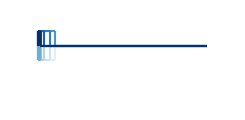

In [506]:
fig, axes = fit_panel_size(
    5,
    3,
    max_figure_height_cm=5.35,
    max_figure_width_cm=8,
    panel_width_cm=8 / 3,
    panel_height_cm=5.35 / 10,
).axis_grid(wspace=0.6, hspace=0.0, as_matrix=True, unmask_n=1)
ax = axes[0, 0]
# fig, ax = plt.subplots(figsize=[4, 4])
eps = 0.005
for j, duration in enumerate(durations[::-1]):
    for intensity in [0, 1]:
        color = cmaps[intensity][j]
        #                 linestyle = "solid" if intensity == 1 else "dashed"
        zorder = 1 if intensity == 1 else 0

        index = cir_view.where_stim_args_index_static(
            dataset.arg_df, intensity=intensity, t_impulse=duration, u=0, v=0
        )
        stim = dataset[index][0][start_index - 1 : stop_index, 721 // 2].cpu()
        indices = torch.nonzero(torch.diff(stim))[:, 0]
        for i, index in enumerate(indices):
            ax.vlines(
                time[index],
                stim[index]+ (eps if intensity == 1 else -eps),
                stim[index + 1]+ (eps if intensity == 1 else -eps),
                linewidth=0.5,
                color=color,
                zorder=zorder,
            )
            try:
                ax.hlines(
                    stim[index + 1] + (eps if intensity == 1 else -eps),
                    time[index],
                    time[indices[i + 1]],
                    linewidth=0.5,
                    color=color,
                    zorder=zorder,
                )
            except IndexError:
                ax.hlines(
                    stim[index + 1] + (eps if intensity == 1 else -eps),
                    time[index],
                    time[-1],
                    linewidth=0.5,
                    color=color,
                    zorder=zorder,
                )

plt_utils.rm_spines(ax)

ylim = np.array(ax.get_ylim())
ylim = (-max(abs(ylim)), max(abs(ylim)))
ax.set_ylim(ylim)

(-1.05, 1.05)

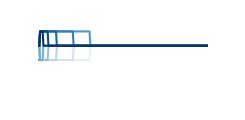

In [503]:
fig, axes = fit_panel_size(
    5,
    3,
    max_figure_height_cm=5.35,
    max_figure_width_cm=8,
    panel_width_cm=8 / 3,
    panel_height_cm=5.35 / 10,
).axis_grid(wspace=0.6, hspace=0.0, as_matrix=True, unmask_n=1)
ax = axes[0, 0]
for j, duration in enumerate(durations[::-1]):
    for intensity in [0, 1]:
        color = cmaps[intensity][j]
        #                 linestyle = "solid" if intensity == 1 else "dashed"
        zorder = 1 if intensity == 1 else 0
        index = cir_view.where_stim_args_index_static(
            dataset.arg_df, intensity=intensity, t_impulse=duration, u=0, v=0
        )
        stim = dataset[index][0][start_index-1:stop_index, 721//2].cpu()
        ax.plot(stim, linewidth=0.5, color=color, zorder=zorder)
ax.hlines(
    0,
    time.min(),
    time.max(),
    linewidth=0.5,
    color="0.5",
    zorder=-1,
)

plt_utils.rm_spines(ax)

ylim = np.array(ax.get_ylim())
ylim = (-max(abs(ylim)), max(abs(ylim)))
ax.set_ylim(ylim)

## Extended Data Fig. 9

### T4c

In [ ]:
strfs = strf_view.where_stim_args(t_impulse=0.02)["T4c"][cluster_indices["T4c"][0]]

In [ ]:
x = strfs[:].mean(axis=0).squeeze().T

#subtracting the spatio-temporal baseline after averaging
x -= x[0].mean(axis=0)

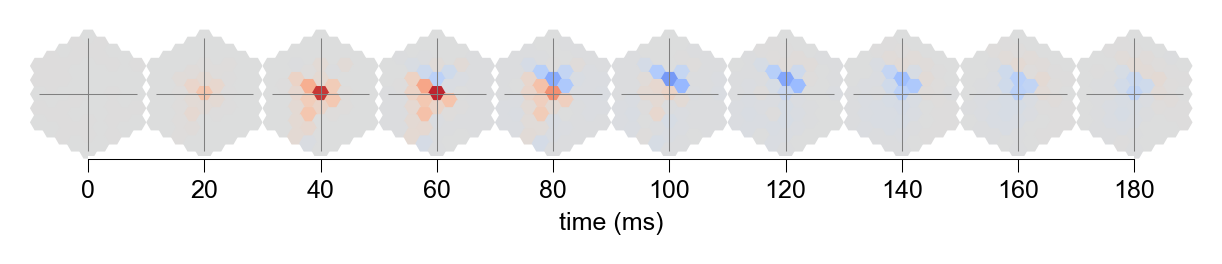

In [ ]:
fig, axes = plot_strf(strfs.time, x)

### T5c

In [ ]:
strfs = strf_view.where_stim_args(t_impulse=0.02)["T5c"][cluster_indices["T5c"][0]]

In [ ]:
x = strfs[:].mean(axis=0).squeeze().T

#subtracting the spatio-temporal baseline after averaging
x -= x[0].mean(axis=0)

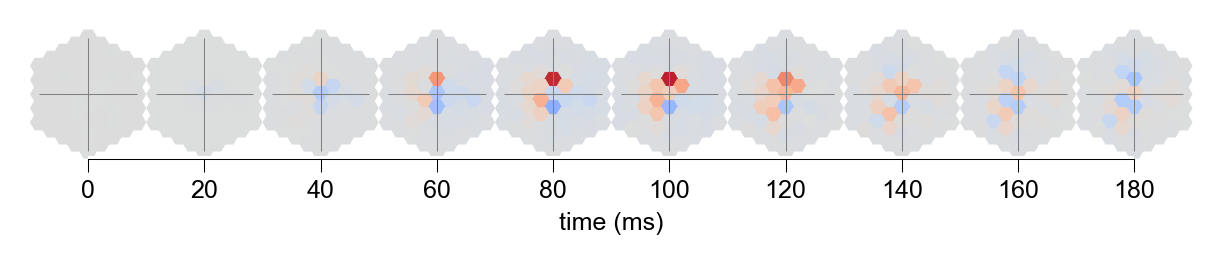

In [ ]:
fig, axes = plot_strf(strfs.time, x)

## f

In [521]:
from flyvision import NetworkView
from flyvision.analysis.optimal_stimuli import plot_stim_response, OptimalStimulus, RegularizedOptimalStimulus

In [530]:
def load_optstim(network_view, cell_type):
    subdir = (
        f"naturalistic_stimuli_responses/{ensemble[0].checkpoints.current_chkpt_key}"
    )
    dir = network_view.dir[subdir]["optstims"][cell_type]
    optstim = OptimalStimulus(dir.stimulus[:], dir.response[:])
    dir = network_view.dir[subdir]["regularized_optstims"][cell_type]
    return RegularizedOptimalStimulus(
        optstim,
        dir.stimulus[:],
        dir.response[:],
        dir.central_predicted_activity[:],
        dir.central_target_activity[:],
        dir.losses[:],
    )

In [533]:
network_view = ensemble[0]

In [534]:
optstims = load_optstim(network_view, "T4c")

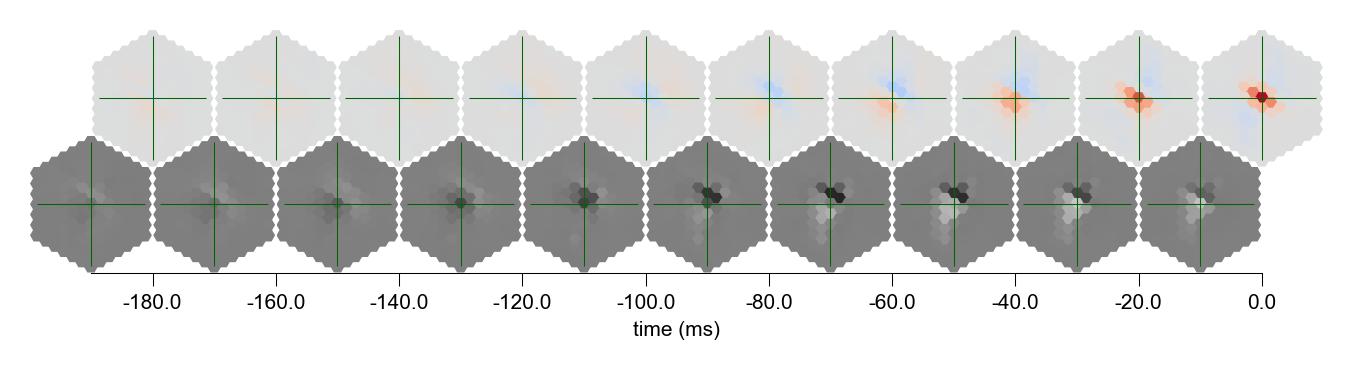

In [535]:
stim_resp_plot = plot_stim_response(
    optstims.regularized_stimulus,
    optstims.response,
    1 / 100,
    *network_view.get_uv("T4c"),
    figsize=[5, 1.6],
    ylabel=None,
    label_peak_response=False,
)

In [536]:
optstims = load_optstim(network_view, "T5c")

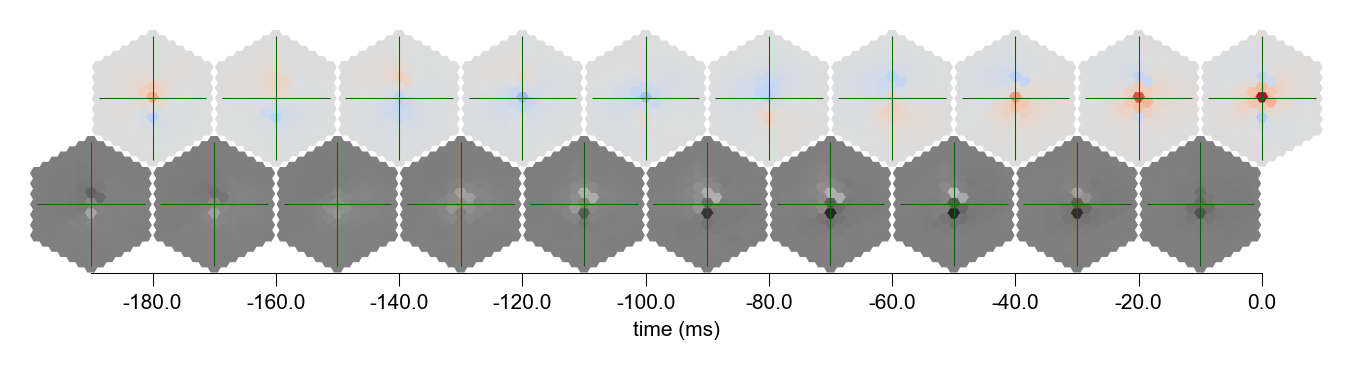

In [537]:
stim_resp_plot = plot_stim_response(
    optstims.regularized_stimulus,
    optstims.response,
    1 / 100,
    *network_view.get_uv("T5c"),
    figsize=[5, 1.6],
    ylabel=None,
    label_peak_response=False,
)